<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> DNN Regressor

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import time, pickle
import pyts
import numpy  as np
from   numpy import mean, std

import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)
 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from imblearn.combine        import SMOTETomek, SMOTEENN

from sklearn.impute          import KNNImputer 
from sklearn.ensemble        import IsolationForest

from sklearn.feature_selection import chi2

from sklearn.preprocessing   import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing   import MaxAbsScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.metrics         import accuracy_score, recall_score, precision_score
from sklearn.metrics         import classification_report, ConfusionMatrixDisplay

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier 
from sklearn.tree            import plot_tree

from sklearn.ensemble        import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from imblearn.ensemble       import EasyEnsembleClassifier 

from sklearn.ensemble        import StackingClassifier, VotingClassifier

import warnings 
warnings.filterwarnings('ignore') 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Importing Dataset

In [2]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes'
estimated_column = 'Class'

data_file  = 'Pima_Diabetes.csv'
data_sheet = 'Pima_Diabetes'

# needed parameters 
RANDOM_STATE =  3
SCORING      = 'accuracy'

# (auto)
data = pd.read_csv( data_file, header=0 ) # , delimiter=','
print(f'there are {data.shape[0]} rows and {data.shape[1]} columns.')

there are 768 rows and 9 columns.


In [3]:
data.shape

(768, 9)

In [4]:
data.columns.to_list()

['Pregnancy',
 'Blood_Plasma',
 'Blood_Pressure',
 'Skin',
 'Test',
 'Body_Mass_Index',
 'Pedi',
 'Age',
 'Class']

In [5]:
data.dtypes

Pregnancy            int64
Blood_Plasma         int64
Blood_Pressure       int64
Skin                 int64
Test                 int64
Body_Mass_Index    float64
Pedi               float64
Age                  int64
Class                int64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pregnancy        768 non-null    int64  
 1   Blood_Plasma     768 non-null    int64  
 2   Blood_Pressure   768 non-null    int64  
 3   Skin             768 non-null    int64  
 4   Test             768 non-null    int64  
 5   Body_Mass_Index  768 non-null    float64
 6   Pedi             768 non-null    float64
 7   Age              768 non-null    int64  
 8   Class            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
data.head()

,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
data.tail()

,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [9]:
#np.random.seed(3)
cm = sns.light_palette('#ffcccb', as_cmap=True)

data.sample(n=10).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
3,111,62,0,0,22.60,0.14,21,0
8,91,82,0,0,35.60,0.59,68,0
2,123,48,32,165,42.10,0.52,26,0
3,99,54,19,86,25.60,0.15,24,0
2,100,64,23,0,29.70,0.37,21,0
0,180,90,26,90,36.50,0.31,35,1
2,129,84,0,0,28.00,0.28,27,0
2,108,62,32,56,25.20,0.13,21,0
3,88,58,11,54,24.80,0.27,22,0
1,88,30,42,99,55.00,0.50,26,1


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - **All** features are **numeric**.
 - As **none** of features are of type **object**, **null values** are NOT in text form (e.g. '?', 'unknown', ' ', ...) which is great. 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Studying the data distribution in each attribute

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Performing Descriptive Statistics

In [10]:
data.describe().T.style.format(precision=1)   

,count,mean,std,min,25%,50%,75%,max
Pregnancy,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Blood_Plasma,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
Blood_Pressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
Skin,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Test,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
Body_Mass_Index,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
Pedi,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Class,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - include 0 which is impossible, and means missing value
 - These 0s must be converted to np.nan

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Converting 0s to np.nan

In [11]:
Features_with_Missing_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index']

df = data.copy()
for ft in Features_with_Missing_Values:
    df[ft] = df[ft].replace(0,np.nan)

In [12]:
df.sample(10).style.\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
5,88.00,66.00,21.00,23.00,24.40,0.34,30,0
3,106.00,54.00,21.00,158.00,30.90,0.29,24,0
4,141.00,74.00,nan,nan,27.60,0.24,40,0
4,94.00,65.00,22.00,nan,24.70,0.15,21,0
4,127.00,88.00,11.00,155.00,34.50,0.60,28,0
1,nan,74.00,20.00,23.00,27.70,0.30,21,0
9,122.00,56.00,nan,nan,33.30,1.11,33,1
2,146.00,70.00,38.00,360.00,28.00,0.34,29,1
2,100.00,64.00,23.00,nan,29.70,0.37,21,0
9,123.00,70.00,44.00,94.00,33.10,0.37,40,0


In [13]:
data = df.copy()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Feature Selection - Variation of Distributions ( Variance or Standard Deviation )
 - Good Variance > 0.1
 - Good STD > 0.3

In [14]:
df = data.std().sort_values(ascending=False)
df

Test               118.775855
Blood_Plasma        30.535641
Blood_Pressure      12.382158
Age                 11.760232
Skin                10.476982
Body_Mass_Index      6.924988
Pregnancy            3.369578
Class                0.476951
Pedi                 0.331329
dtype: float64

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - The feature **Pedi** has very low variation in distribution. Thus it has little use and should be removed.
 - The feature **Class** also has low variation which suggests count of one of the classes prevails the rest, but, as it is the **tatget columns**, it will be kept.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Sorting Features Based on Variation

In [15]:
data = data[ list( df.index ) ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Dropping the feature 'Pedi'

In [16]:
data.drop(['Pedi'],axis=1,inplace=True)
data.columns.to_list()

['Test',
 'Blood_Plasma',
 'Blood_Pressure',
 'Age',
 'Skin',
 'Body_Mass_Index',
 'Pregnancy',
 'Class']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Studying Histogram of Features

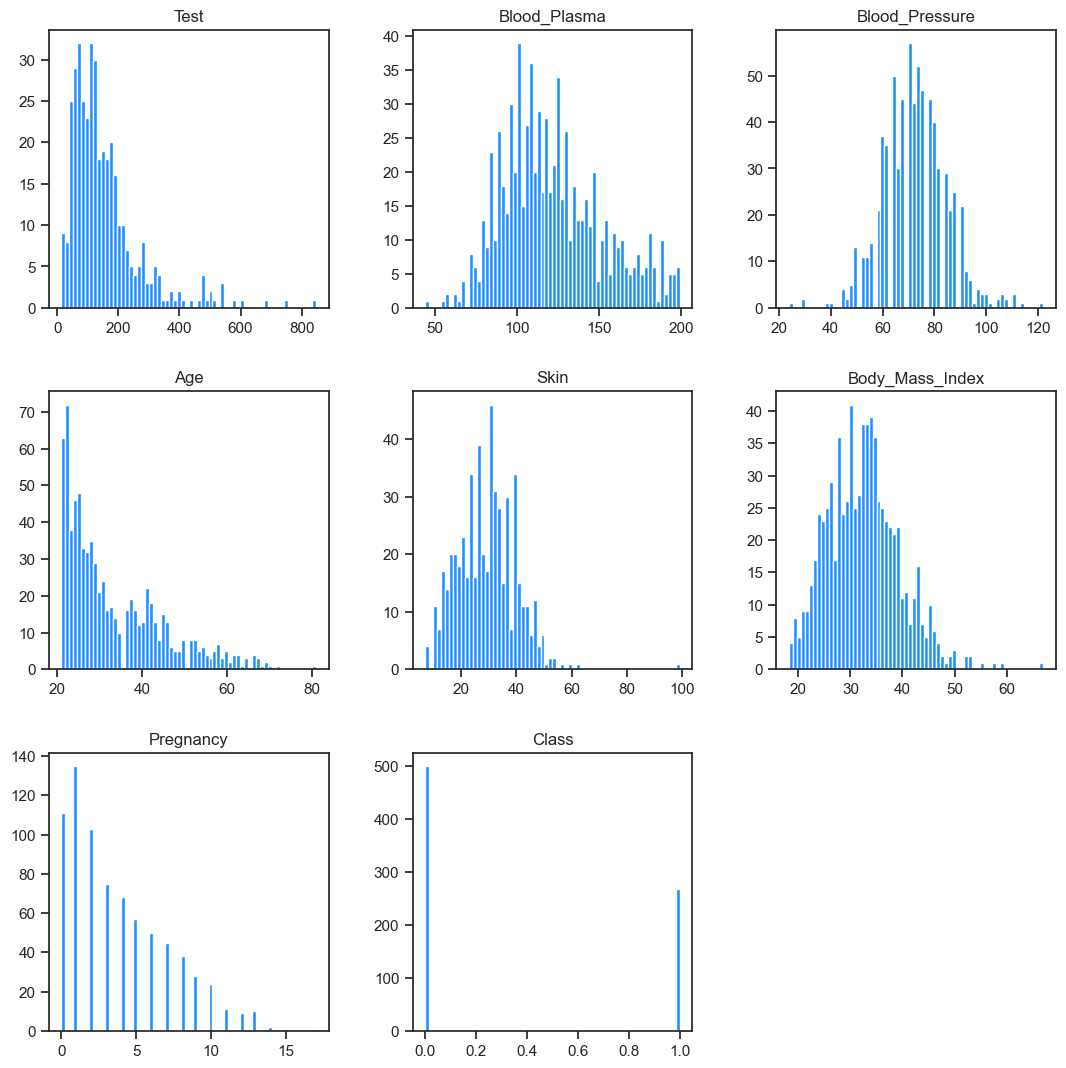

In [17]:
data.hist(bins=64,grid=False,color='dodgerblue',figsize=(13,13)); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - Notable **Skewness** is observed in histogram of features **Skin**, **Test**, **Body_Mass_Index** and **Age** which suggests existence of outliers.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Shape Parameters: Skewness and Kurtosis

In [18]:
SKEW = data.skew() 
KURT = data.kurt() 

Shape_Parameters = pd.DataFrame([KURT,SKEW]).T
Shape_Parameters.columns = ['Kurtosis','Skewness']
Shape_Parameters.sort_values(['Kurtosis','Skewness'],ascending=[False,False],inplace=True)
Shape_Parameters

,Kurtosis,Skewness
Test,6.370522,2.166464
Skin,2.935491,0.690619
Blood_Pressure,0.911158,0.134153
Body_Mass_Index,0.863379,0.593970
Age,0.643159,1.129597
Pregnancy,0.159220,0.901674
Blood_Plasma,-0.277040,0.530989
Class,-1.600930,0.635017


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - **Test** has a very thick tail at right. Most possibly extreme outliers exist.
 - **Skin** has a thick tail at the right. Most possibly many outliers exist.
 - **Blood_Pressure**, **Body_Mass_Index** and **Age** have a thick tail at right. Possibly many outliers exist.
 - **Pregnancy** has a tail at right. Possibly some outliers exist.     
    
 - All other features have **negative kurtosis** which suggest no tail, thus no outliers.
 - **Blood_Plasma** and **Class** have some skewness to the right. which suggest imbalanced distribution of records, not outliers.

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Distribution of Target Column

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Distribution Visualization

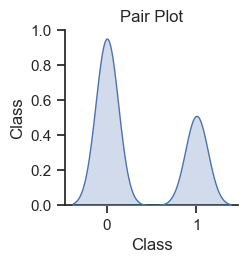

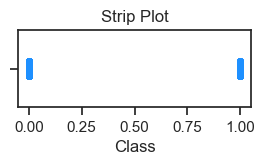

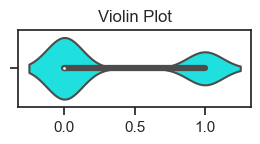

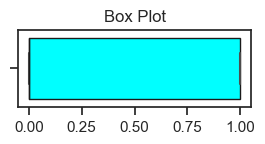

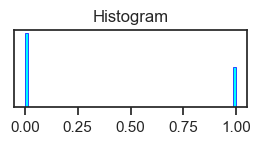

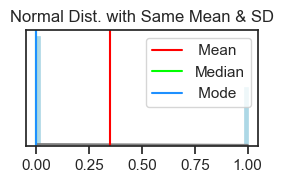

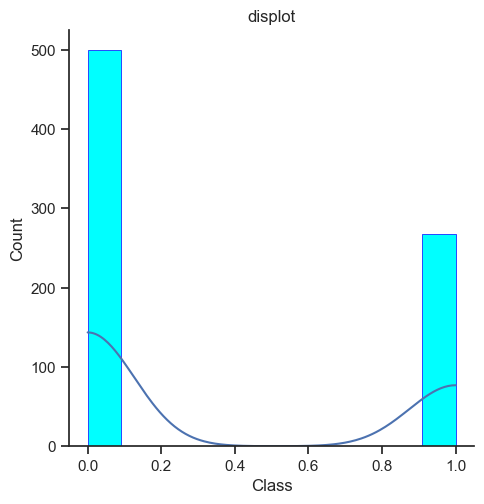

In [19]:
ft = 'Class'
L  = data[ft].copy()

# pair-plot
sns.pairplot( data[[ft]], diag_kind='kde' ) 
plt.title('Pair Plot')
plt.show()

# strip-plot
plt.figure(  figsize=(3,1)  )
sns.stripplot( data=data, x=ft, color='dodgerblue' )
plt.title('Strip Plot')
plt.show()

# ViolinPlot
plt.figure(  figsize=(3,1)  )
sns.violinplot( x=L
              , color = 'cyan'
              )
plt.title('Violin Plot')
plt.xlabel('')  
plt.xlabel('')
plt.show()

# BoxPlot
boxprops    = dict( edgecolor = 'k', facecolor  = 'cyan', linewidth = 1 )
medianprops = dict( color     = 'k', linewidth  = 1  )
flierprops  = dict( marker    = 'd', markersize = 7, markerfacecolor = 'red', markeredgecolor = 'red' ) 
                  
plt.figure(  figsize=(3,1)  )
sns.boxplot( x=L
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
plt.title('Box Plot')
plt.xlabel('') 
plt.show()

# Histogram: 
fig, ax = plt.subplots( figsize=(3,1) )
ax.hist( L, density=True, bins=64, linewidth=.5, edgecolor='blue', facecolor='cyan' )
ax.set_yticks([])
plt.title('Histogram')
plt.show()

# Density Curve:
from scipy.stats import norm 
h = sorted( np.asarray(L) ) 
fit = norm.pdf( h, np.mean(h), np.std(h) )
fig, ax = plt.subplots( figsize=(3,1.5) )
ax.plot( h, fit, color='gray', linestyle='-', linewidth=1.5 )
ax.hist( L, density=True, bins=64, linewidth=.5, edgecolor='lightblue', facecolor='lightblue' )
Mean = L.mean()
Median = L.median()
Mode = L.mode() 
plt.axvline(Mean,color='red',linewidth=1.5,label=' Mean')
plt.axvline(Median,color='lime',linewidth=1.5,label='Median')
for i in range(len(Mode)): plt.axvline(Mode[i],color='dodgerblue',linewidth=1.5,label=' Mode')
ax.set_yticks([]) 
ax.legend()
plt.title('Normal Dist. with Same Mean & SD')
plt.show()

# displot:
sns.displot(data=data, x=ft, kde=True, linewidth=.5, edgecolor='blue', facecolor='cyan')
plt.title('displot')
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - Visually, it is observed that the **Target Column** has an **Imbalanced Distribution**

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Counting Subcats

In [20]:
data['Class'].value_counts()

Class
0    500
1    268
Name: count, dtype: int64

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
 - Distribution of **Class** is **Imbalaned**, Possibly some classifiers demonstrate extremely week performance in detecting **class 1** which is in minority.

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Pre-Porocessing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Handling Duplicates

In [21]:
print('Before Treatment:\nn duplicates =', sum(data.duplicated())) 

Before Treatment:
n duplicates = 0


In [22]:
if sum( data.duplicated() ) > 0:
    data = data.drop_duplicates()
    data.index = range( data.shape[0] )
print('After Treatment:\nn duplicates =', sum(data.duplicated())) 

After Treatment:
n duplicates = 0


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Handling Missing Values by KNNImputer

In [23]:
print('Before Treatment:\n', pd.DataFrame(data.isnull().sum(), columns=['Number of Missing Values'])) 

Before Treatment:
                  Number of Missing Values
Test                                  374
Blood_Plasma                            5
Blood_Pressure                         35
Age                                     0
Skin                                  227
Body_Mass_Index                        11
Pregnancy                               0
Class                                   0


In [24]:
imputer = KNNImputer( n_neighbors=2, weights="distance" )   # data.fillna( data.median(), inplace=True )
Imputed_Values = imputer.fit_transform( data.values )
data = pd.DataFrame( Imputed_Values, columns=data.columns )
print('After Treatment:\n', pd.DataFrame(data.isnull().sum(), columns=['Number of Missing Values'])) 

After Treatment:
                  Number of Missing Values
Test                                    0
Blood_Plasma                            0
Blood_Pressure                          0
Age                                     0
Skin                                    0
Body_Mass_Index                         0
Pregnancy                               0
Class                                   0


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Handling Outliers

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Detecting Outliers by Boxplots

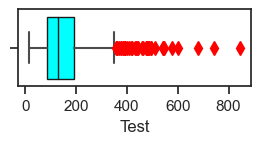

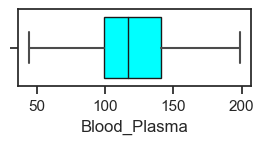

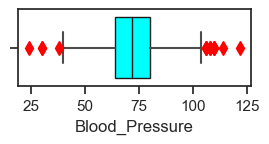

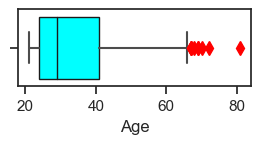

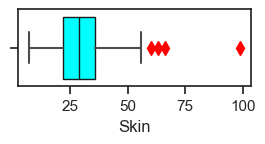

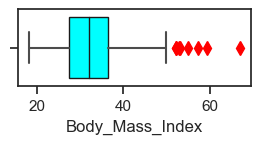

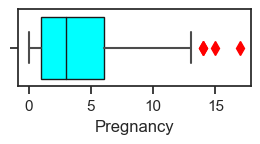

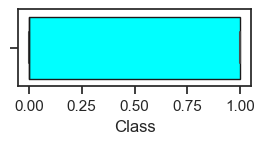

In [25]:
df = data.copy()

scalar_columns = []
for col in df.columns:
    if df[col].dtype!='object': scalar_columns.append( col )

boxprops    = dict( linewidth=1, edgecolor='k', facecolor='cyan' )
medianprops = dict( linewidth=1, color='k' )
flierprops  = dict( marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red' )

for ft in scalar_columns:
    plt.figure(  figsize=(3,1)   )
    sns.boxplot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Winsorizing Extreme Outliers by Z-Score

In [26]:
# Winsorizing Extreme Outliers
df_dirty = data.copy()    
columns_with_outliers = [ 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Age' ]

def winsorize_by_zscore(df,ft):
    x  = df[ft].copy()
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[ (z > upper_bound) 
                 | (z < lower_bound) ]
    
    x_Des=sorted(x,reverse=True)
    i=0
    while x_Des[i] >=  M + 3*SD:
        i=i+1 
    MAX=x_Des[i] 
    
    x_Asc=sorted(x,reverse=False)
    i=0 
    while x_Asc[i] <=  M - 3*SD:
        i=i+1  
    MIN=x_Asc[i] 
    
    for i in range(0,len(x)):
        if   z[i] > upper_bound: x[i]=MAX
        elif z[i] < lower_bound: x[i]=MIN
            
    return [x, ls]
 

# df_no_extreme
df = df_dirty.copy()

index_list = []
for c in columns_with_outliers:
    c_clean, ls = winsorize_by_zscore( df_dirty, c )
    index_list.extend( ls )
    df.loc[ :, c ] = c_clean

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Checking

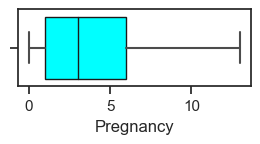

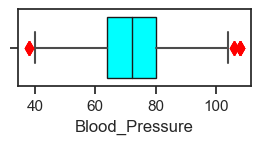

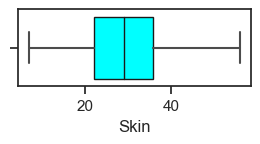

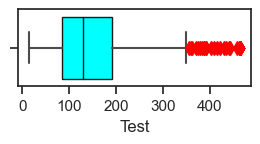

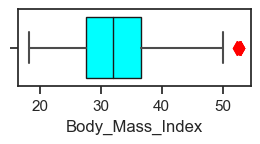

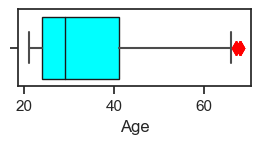

In [27]:
# Detecting Outliers by Boxplots 
for ft in columns_with_outliers:
    plt.figure(  figsize=(3,1)   )
    sns.boxplot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning

In [28]:
data = df.copy()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Noise (Outliers) by AODs
 - Isolation Forest

In [29]:
df_dirty = data.copy()    

X   = df_dirty[ scalar_columns ].values.copy()
AOD = IsolationForest( contamination=0.05 ).fit( X )
flag_clean = AOD.predict( X ) == +1
df_clean   = df_dirty.loc[ flag_clean, : ]
df_clean.index = range(df_clean.shape[0])

df = df_clean.copy()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing Noise (Outliers) Before Vs After Treating by AODs

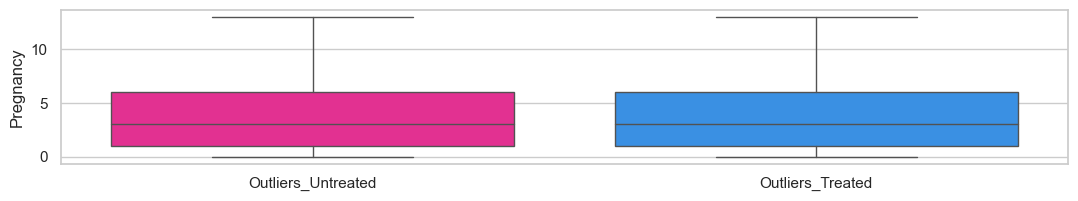

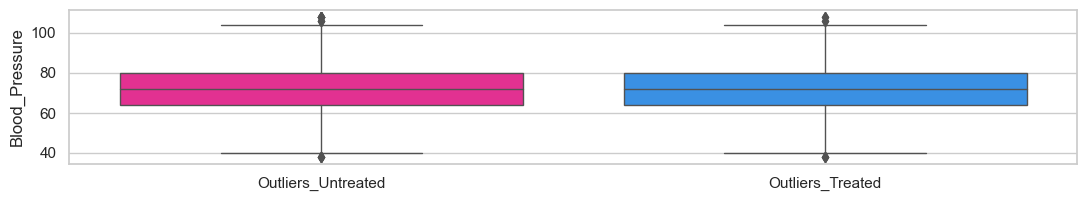

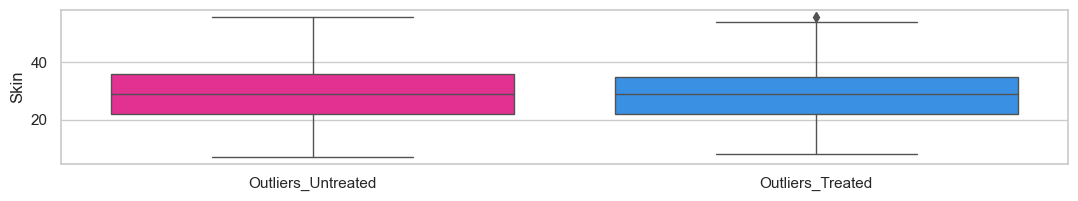

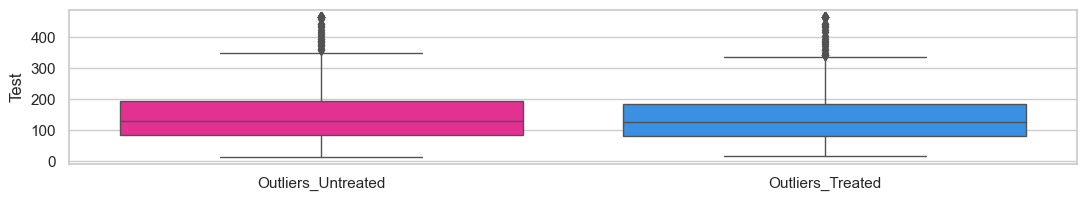

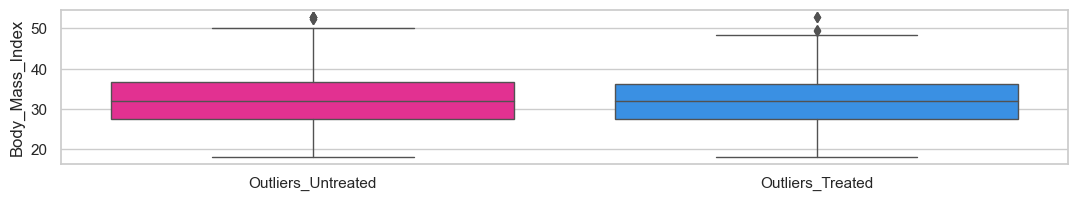

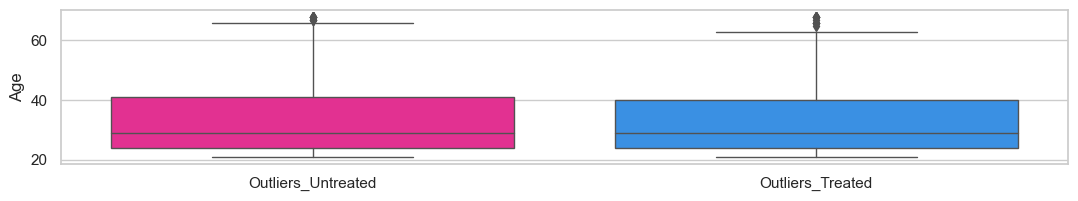

In [30]:
df_before = data.copy()
df_before['condition']=['Outliers_Untreated']*df_before.shape[0]
df_after  = df.copy()
df_after['condition'] =['Outliers_Treated']*df_after.shape[0]
df_before_after = pd.concat([df_before,df_after],axis=0)
df_before_after.head()

x   = 'condition'
for y in columns_with_outliers:
    Xy = df_before_after[ [x,y] ].copy().dropna().sort_values([x],ascending=[False]) 
    # BoxPlot
    sns.set(rc={'figure.figsize':(13,2)}); sns.set(style='whitegrid')
    sns_plot = sns.boxplot( x=x, y=y, data=Xy, linewidth=1.0, palette=['deeppink','dodgerblue']); sns_plot.set_xlabel('')
    fig = sns_plot.get_figure(); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Feature Selection - Heat-Map of Correlations
 - As the data is cleaned, **Pearson's r** correlation method can be used.

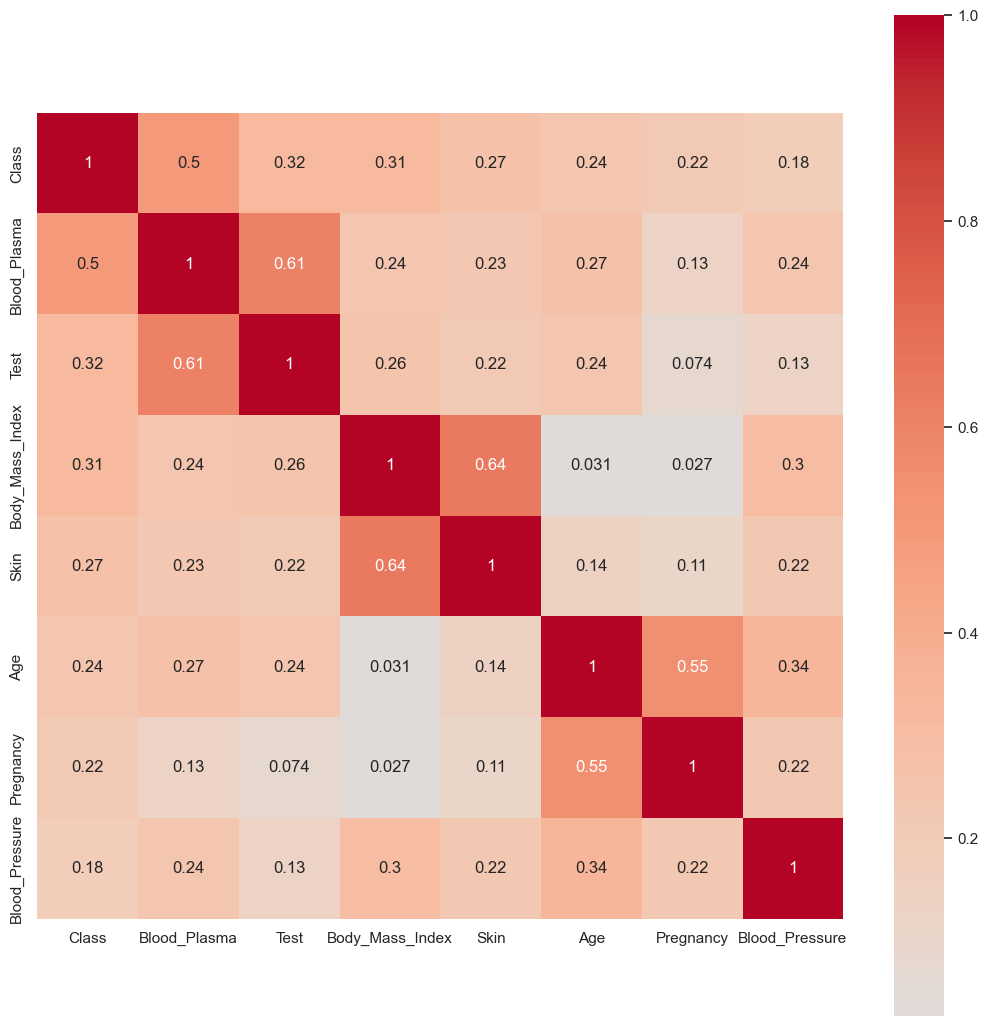

In [31]:
Corr = data.corr('pearson')
Corr.sort_values(['Class'],ascending=[False],inplace=True)
Corr = Corr.T
Corr.sort_values(['Class'],ascending=[False],inplace=True)

fig,ax = plt.subplots(figsize=(13,13))
sns_plot = sns.heatmap( Corr, mask=np.zeros_like(Corr,dtype=bool), 
                        cmap='coolwarm',
                        square=True, ax=ax, annot=True, center=0.00 )
plt.show()

In [32]:
Threshhold = 0.01

strongly_correlated = list( Corr[ Corr['Class']> 0.70 ].index )
weakly_correlated   = list( Corr[ Corr['Class']< Threshhold ].index )

print( '\n strongly-correlated features: \n', strongly_correlated )
print( '\n weakly-correlated features: \n', weakly_correlated )


 strongly-correlated features: 
 ['Class']

 weakly-correlated features: 
 []


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report
    
 - Correlation of any feature to **Target Column: Class** is less than 70%
 - **linear models** **( LinearSVC, LogisticRegression, PassiveAggressive, Perceptron, Ridge, SGD, SGDOneClassSVM )**, 
   will have weak performane.
 - **Nonlinear Models** like **Decision Tree** Should be used.
** **
 - None of features are less than 1% correlated to **Target Column: Class** and can be kept.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Sorting Features Based on Correlation

In [33]:
data = data[ list(Corr.columns) ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Dropping Weakly-Correlated Features

In [34]:
data.drop( weakly_correlated, axis=1, inplace=True )
data.columns.to_list()

['Class',
 'Blood_Plasma',
 'Test',
 'Body_Mass_Index',
 'Skin',
 'Age',
 'Pregnancy',
 'Blood_Pressure']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Feature Selection - Chi-Squared Test

In [35]:
df = data.copy()

X = df.drop([estimated_column],axis=1) 
y = df[estimated_column]
X_pvals = chi2(X,y)

# feature p values
# p value <= 0.05  means  strong feature
ft_pvals = pd.Series( X_pvals[1] )
ft_pvals.index = X.columns

# important & unimportant features
important_features   = list( ft_pvals[ft_pvals<=0.05].sort_values( ascending=True ).index )
unimportant_features = list( ft_pvals[ft_pvals> 0.05].sort_values( ascending=True ).index )

print( '\nChi-Squares P-Value Results:\n' )
print( (pd.DataFrame(ft_pvals,columns=['P_Value'])).sort_values(['P_Value']) )
print( '\n  Important_features:',   important_features )
print( '\nUnImportant_features:', unimportant_features )


Chi-Squares P-Value Results:

                      P_Value
Blood_Plasma     0.000000e+00
Test             0.000000e+00
Age              9.024823e-42
Skin             7.961368e-39
Pregnancy        3.281155e-25
Body_Mass_Index  6.691147e-25
Blood_Pressure   1.425820e-12

  Important_features: ['Blood_Plasma', 'Test', 'Age', 'Skin', 'Pregnancy', 'Body_Mass_Index', 'Blood_Pressure']

UnImportant_features: []


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Findings Report 
 - All Features Pass the Chi-Squared Test and are Important

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Dropping Unimportant Features

In [36]:
data.drop( unimportant_features, axis=1, inplace=True )
data.columns.to_list()

['Class',
 'Blood_Plasma',
 'Test',
 'Body_Mass_Index',
 'Skin',
 'Age',
 'Pregnancy',
 'Blood_Pressure']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Pair-Plot

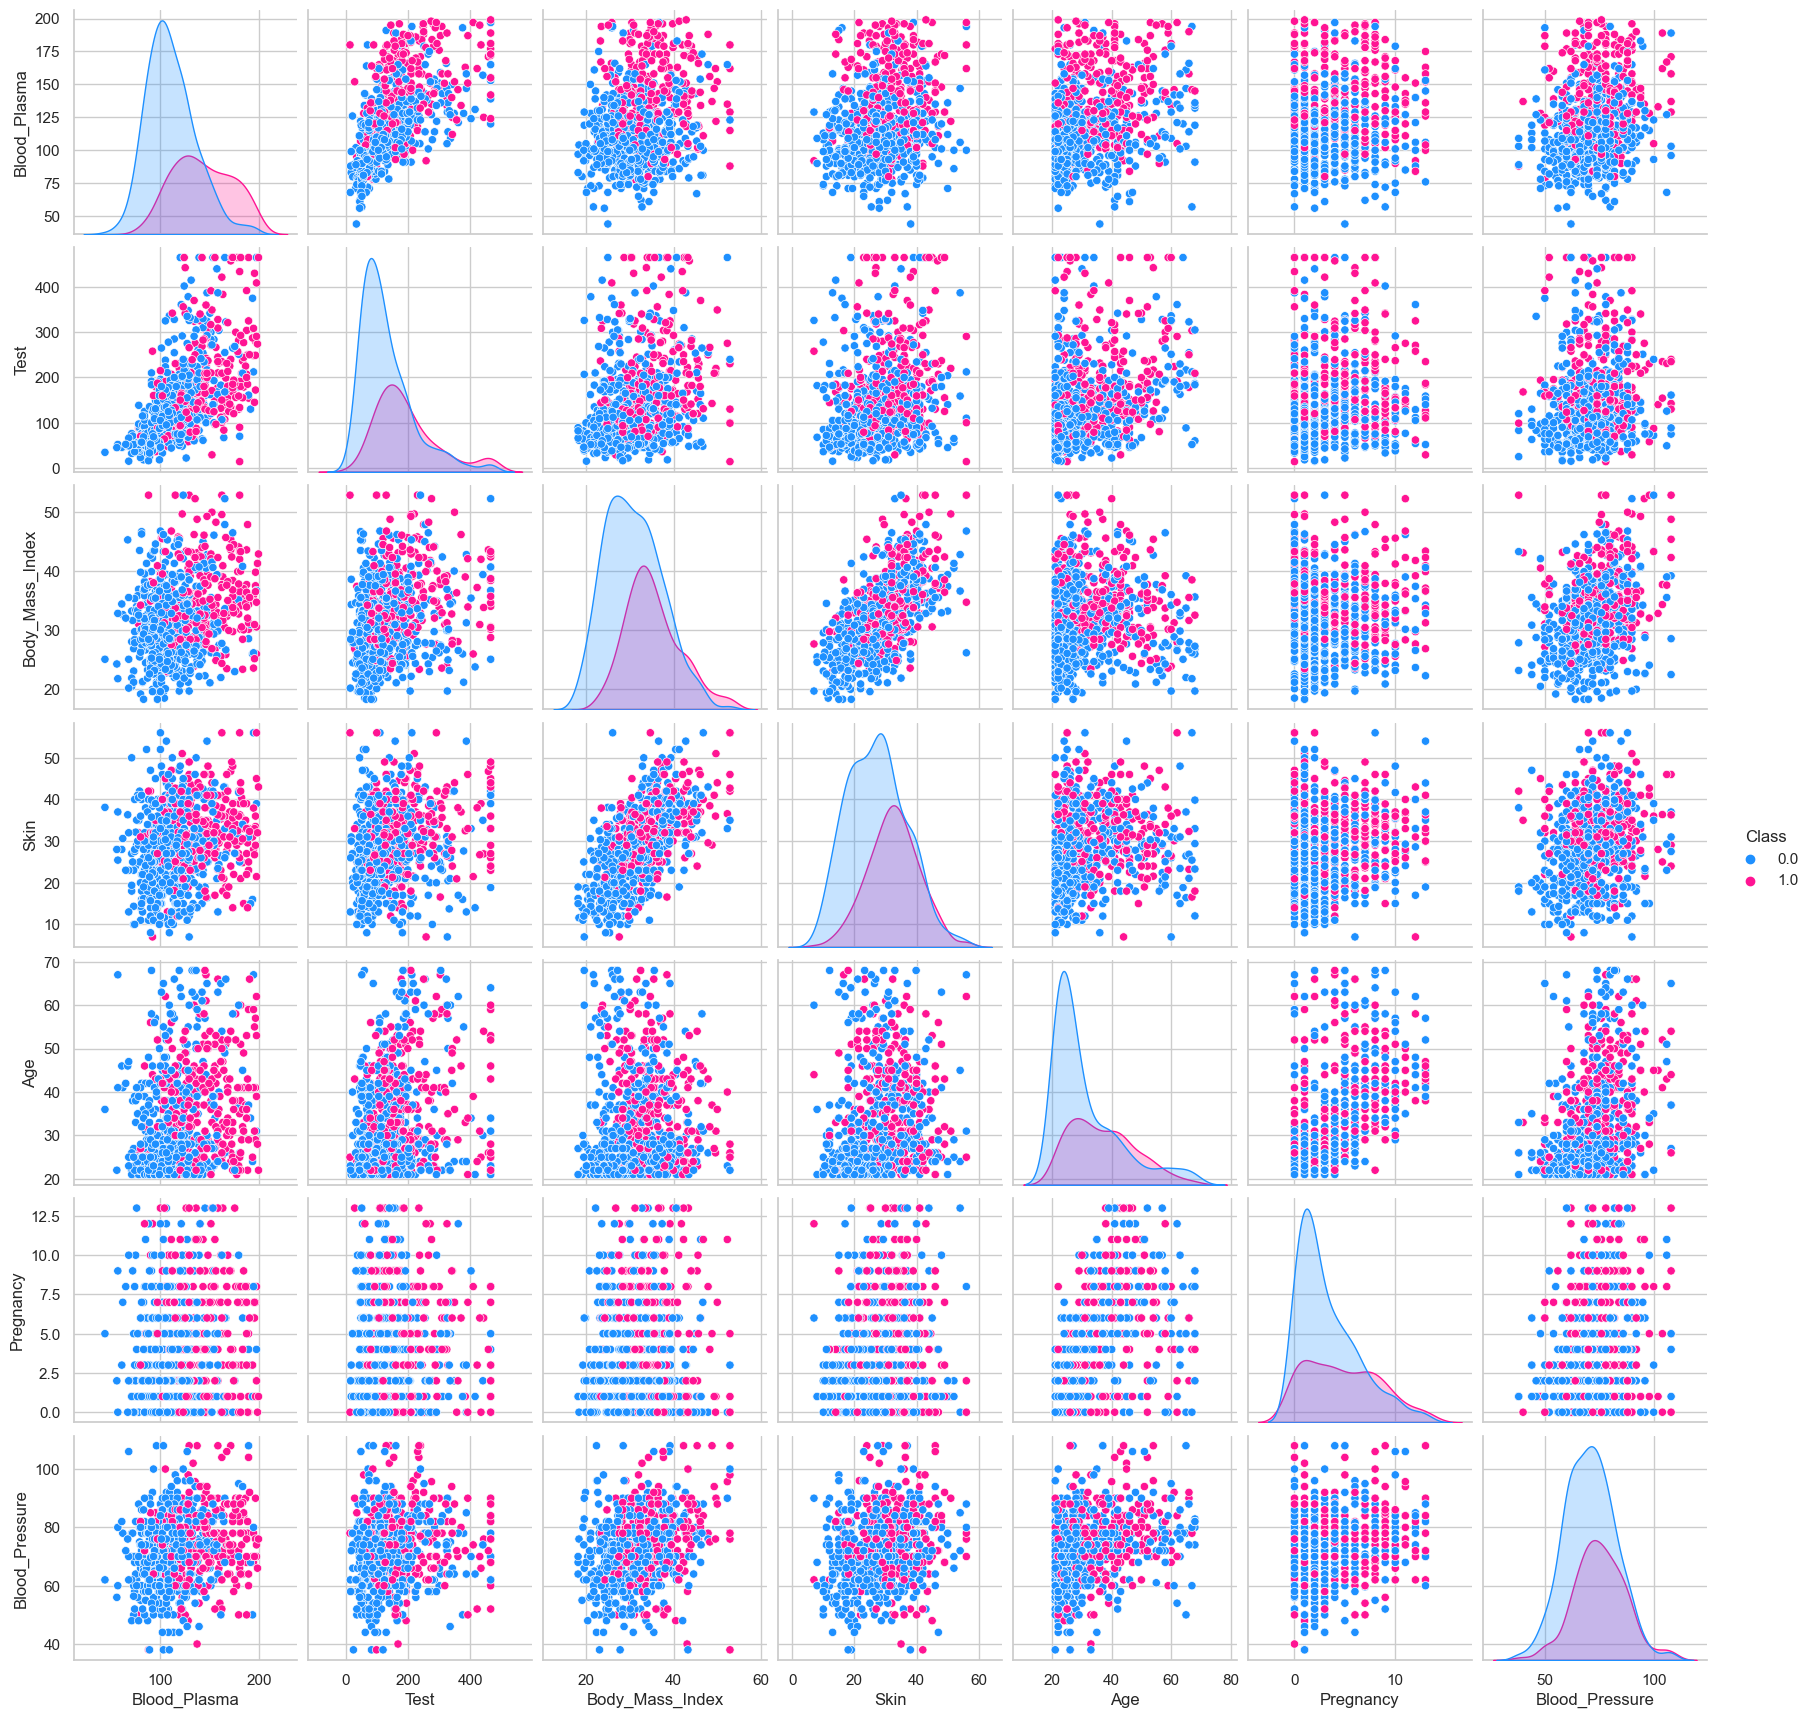

In [37]:
sns.pairplot( data, hue='Class', diag_kind='kde', palette=['dodgerblue','deeppink'] ); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Splitting the data into training, validation and test set in the ratio of 60:20:20 respectively.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Splitting into X and y

In [38]:
X = data.drop(['Class'], axis=1).copy()  # X_df = data.loc[ :, data.columns != 'Personal Loan' ]  
y = data['Class'].copy()                 # y_df = data.loc[ :, data.columns == 'Personal Loan' ]  
y = LabelEncoder().fit_transform( y )

In [39]:
X.shape

(768, 7)

In [40]:
y.shape

(768,)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Splitting into Train, Valid and Test Sets

In [41]:
X_Train_Valid, X_Test, y_Train_Valid, y_Test  =  train_test_split(        
          X, y
        , random_state  =  RANDOM_STATE
        , test_size     =  15/100
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train_Valid.index = range( X_Train_Valid.shape[0] )
X_Test.index        = range( X_Test.shape[0]        ) 

X = X_Train_Valid
y = y_Train_Valid

X_Train, X_Valid, y_Train, y_Valid  =  train_test_split(        
          X, y
        , random_state  =  RANDOM_STATE
        , test_size     =  15/80
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train.index = range( X_Train.shape[0] )
X_Valid.index = range( X_Valid.shape[0] ) 

In [42]:
X_Train.shape

(529, 7)

In [43]:
X_Valid.shape

(123, 7)

In [44]:
X_Test.shape

(116, 7)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Counting Subcats of Sets

In [45]:
pd.crosstab( y_Train, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,344
1,185


In [46]:
pd.crosstab( y_Valid, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,80
1,43


In [47]:
pd.crosstab( y_Test, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,76
1,40


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checking Imbalance in Data

col_0  count
Class       
0.0      500
1.0      268


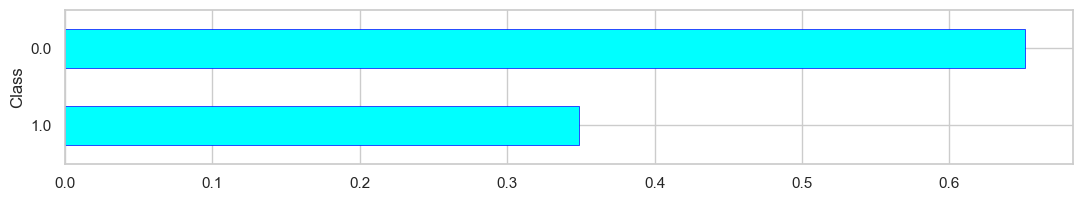

In [48]:
df = data.copy()
x  = estimated_column

# Frequency Table  
freq_tab = pd.crosstab( index=df[x].astype('str'), columns='count' )
print(freq_tab.sort_values('count',ascending=False))

# Barh
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan'); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - Data is **Imbalanced** and needs treatment.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:red;"> Mistreating Imbalance

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Mistreating Imbalance by SMOTETomek

In [49]:
Sampler = SMOTETomek()

X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train, y_Train )
X_Valid_Balanced, y_Valid_Balanced = Sampler.fit_resample( X_Valid, y_Valid )
X_Test_Balanced , y_Test_Balanced  = Sampler.fit_resample( X_Test , y_Test  )

X_Train_Balanced.index = range(X_Train_Balanced.shape[0])
X_Valid_Balanced.index = range(X_Valid_Balanced.shape[0])
X_Test_Balanced.index  = range(X_Test_Balanced.shape[0] )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Checking Balanced Data

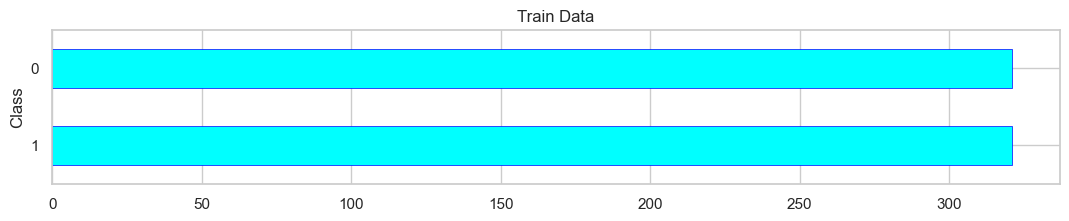

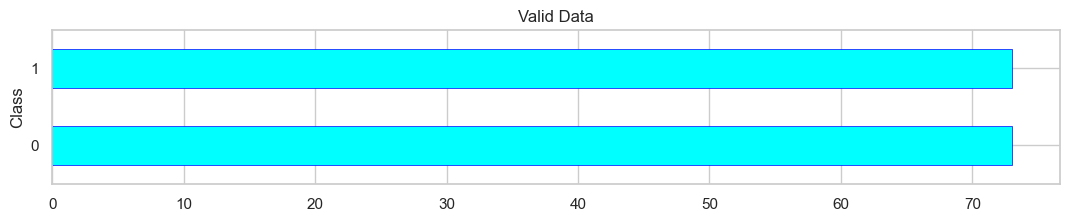

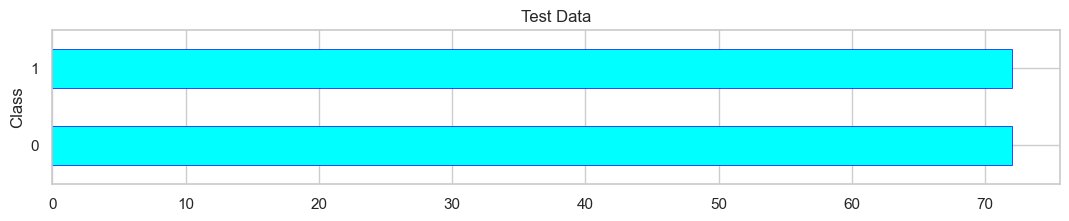

In [50]:
x = estimated_column

df_Train_Balanced      = X_Train_Balanced.copy()
df_Train_Balanced[ x ] = y_Train_Balanced.copy()

df_Valid_Balanced = X_Valid_Balanced.copy()
df_Valid_Balanced[ x ] = y_Valid_Balanced.copy()

df_Test_Balanced  = X_Test_Balanced.copy()
df_Test_Balanced[ x ]  = y_Test_Balanced.copy()

# Train Data
df = df_Train_Balanced.copy() 
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Train Data'); plt.show()

# Valid Data
df = df_Valid_Balanced.copy()
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Valid Data'); plt.show()

# Test Data
df = df_Test_Balanced.copy()
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Test Data'); plt.show()


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - After Mistreatment, Data is **Balanced**

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Warning: 
 - Although Mistreated Data looks Charming and Tempting, unfortunately, the models trained by them are overfit and have weak performance.
 - A better solution to overcome the imbalance, is to train the models with the imbalanced data, and boost them via gradient-boost.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> (NOT) Assigning 

In [51]:
#X_Train = X_Train_Balanced.copy();           y_Train = y_Train_Balanced.copy()
#X_Valid = X_Valid_Balanced.copy();           y_Valid = y_Valid_Balanced.copy()
#X_Test  = X_Test_Balanced.copy();            y_Test  = y_Test_Balanced.copy()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [52]:
from openpyxl       import Workbook
from openpyxl.utils import get_column_letter
from openpyxl       import load_workbook

wb = Workbook()
dest_filename = 'DataSets.xlsx'
Empty = wb.active; Empty.title='Empty'     


XX = data.values.copy() 
DATA = wb.create_sheet('DATA')
DATA.append( list(data.columns) )
for i in range( XX.shape[0] ): DATA.append( list( XX[i,:] )  )

    
XX = X_Train.values.copy()    
xTrain = wb.create_sheet('xTrain')
xTrain.append( list(X_Train.columns) )
for i in range( XX.shape[0] ): xTrain.append( list( XX[i,:] )  )
                                                  
YY = y_Train.copy()    
yTrain = wb.create_sheet('yTrain')
yTrain.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTrain.append([  YY[i], YY[i]  ])

    
XX = X_Valid.values.copy()    
xValid = wb.create_sheet('xValid')
xValid.append( list(X_Valid.columns) )
for i in range( XX.shape[0] ): xValid.append( list( XX[i,:] )  )
                                                  
YY = y_Valid.copy()    
yValid = wb.create_sheet('yValid')
yValid.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yValid.append([  YY[i], YY[i]  ])

    
XX = X_Test.values.copy()    
xTest = wb.create_sheet('xTest')
xTest.append( list(X_Test.columns) )
for i in range( XX.shape[0] ): xTest.append( list( XX[i,:] )  )
                                                  
YY = y_Test.copy()    
yTest = wb.create_sheet('yTest')
yTest.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTest.append([  YY[i], YY[i]  ])


# Saving    
wb.save( filename = dest_filename )   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [53]:
DataSet = 'DataSets.xlsx'

data    =           pd.read_excel( DataSet, 'DATA'  , header=0 )

X_Train =           pd.read_excel( DataSet, 'xTrain', header=0 )
y_Train = np.array( pd.read_excel( DataSet, 'yTrain', header=0 ).iloc[:,0] )

X_Valid =           pd.read_excel( DataSet, 'xValid', header=0 )
y_Valid = np.array( pd.read_excel( DataSet, 'yValid', header=0 ).iloc[:,0] )

X_Test  =           pd.read_excel( DataSet, 'xTest' , header=0 )
y_Test  = np.array( pd.read_excel( DataSet, 'yTest' , header=0 ).iloc[:,0] )

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Scaling

In [54]:
Scaler0 = None
Scaler1 = StandardScaler()    # z-score
Scaler2 = MinMaxScaler()      # 0  1
Scaler3 = MaxAbsScaler()      # 0+ 1
Scaler4 = PowerTransformer()
Scaler5 = FunctionTransformer(np.log1p)
Scaler6 = FunctionTransformer(np.exp)

Scaler  = Scaler1

if Scaler == None:
    X_Train_Scaled = X_Train.copy()
    X_Valid_Scaled = X_Valid.copy()
    X_Test_Scaled  = X_Test.copy()
else:
    X_Train_Scaled = pd.DataFrame( Scaler.fit_transform(X_Train), columns=X_Train.columns )
    X_Valid_Scaled = pd.DataFrame( Scaler.fit_transform(X_Valid), columns=X_Valid.columns )
    X_Test_Scaled  = pd.DataFrame( Scaler.fit_transform(X_Test),  columns=X_Test.columns  )

In [55]:
X_Train_Scaled.sample(5)

,Blood_Plasma,Test,Body_Mass_Index,Skin,Age,Pregnancy,Blood_Pressure
468,-1.348526,-1.184454,-0.836957,-1.196636,-0.813888,-0.872576,-0.018237
91,0.617890,0.902679,0.017671,-0.334863,-0.985080,-1.176055,0.969019
39,0.716210,0.495964,0.916503,0.311467,0.298857,0.037863,0.804476
60,-1.119111,-1.049859,-0.483318,-1.088915,-0.985080,-0.569096,0.146306
209,0.978399,0.171845,0.282900,0.526910,-0.043526,1.555261,0.475391


** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Keras

In [66]:
from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation
from keras.optimizers import Adam

In [74]:
model = Sequential()

model.add( Dense( units=128, input_dim=X_Train_Scaled.shape[1] ) )
model.add( Dropout(0.2)       )
model.add( Activation('relu') )

model.add( Dense( units=16 )  )
model.add( Activation('relu') )
model.add( Dense( units=16 )  )
model.add( Activation('relu') )

model.add( Dense( units=1 )   )
model.add( Activation('sigmoid') )

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               1024      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 activation_20 (Activation)  (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 16)                2064      
                                                                 
 activation_21 (Activation)  (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 activation_22 (Activation)  (None, 16)               

In [75]:
model.compile(
    optimizer = Adam( learning_rate=0.0001 ),
    loss = 'mean_squared_error',
    metrics=['mae']
             )

In [123]:
training = model.fit( 
    epochs     = 20,
    x          = X_Train_Scaled, 
    y          = y_Train, 
    batch_size = 25,
    validation_data       = (X_Valid_Scaled, y_Valid),
    validation_batch_size =  25
                   )

Epoch 1/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0658 - mae: 0.1488 - val_loss: 0.1735 - val_mae: 0.2586
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 0.0758 - mae: 0.1618 - val_loss: 0.1732 - val_mae: 0.2584
Epoch 3/20
22/22 [==============================] - 0s 5ms/step - loss: 0.0720 - mae: 0.1588 - val_loss: 0.1740 - val_mae: 0.2590
Epoch 4/20
22/22 [==============================] - 0s 4ms/step - loss: 0.0641 - mae: 0.1495 - val_loss: 0.1737 - val_mae: 0.2589
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 0.0655 - mae: 0.1529 - val_loss: 0.1730 - val_mae: 0.2573
Epoch 6/20
22/22 [==============================] - 0s 4ms/step - loss: 0.0655 - mae: 0.1507 - val_loss: 0.1724 - val_mae: 0.2565
Epoch 7/20
22/22 [==============================] - 0s 4ms/step - loss: 0.0645 - mae: 0.1494 - val_loss: 0.1734 - val_mae: 0.2570
Epoch 8/20
22/22 [==============================] - 0s 5ms/step - loss: 0.0685 - mae: 0.15

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


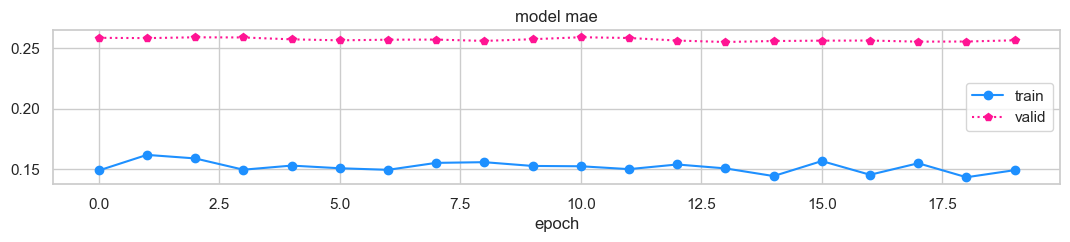

In [124]:
print(training.history.keys())
plt.plot(training.history['mae'],'-o',color='dodgerblue')
plt.plot(training.history['val_mae'],':p',color='deeppink')
plt.title('model mae')
plt.xlabel('epoch')
plt.legend(['train','valid'],loc='best')
plt.show()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


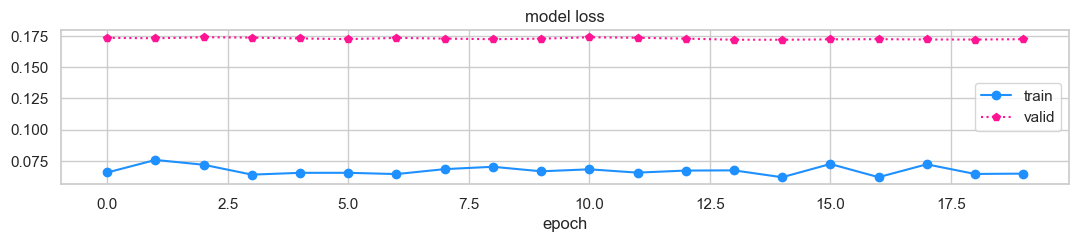

In [125]:
print(training.history.keys())
plt.plot(training.history['loss'],'-o',color='dodgerblue')
plt.plot(training.history['val_loss'],':p',color='deeppink')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train','valid'],loc='best')
plt.show()

4/4 [==============================] - 0s 2ms/step


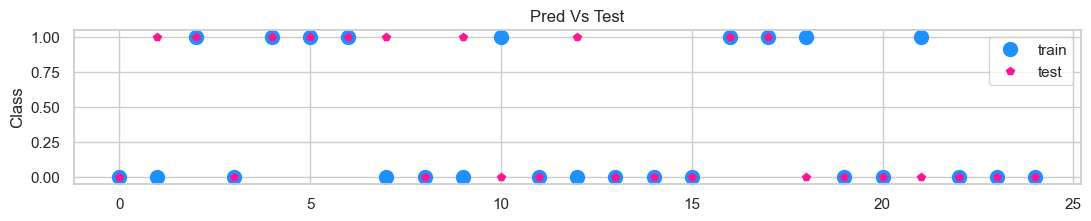

In [126]:
y_Pred = model.predict(X_Test_Scaled)
y_Pred = np.round(y_Pred)
plt.plot(y_Test[:25],'o',color='dodgerblue',markersize=10)
plt.plot(y_Pred[:25],'p',color='deeppink')
plt.title('Pred Vs Test')
plt.ylabel(estimated_column)
plt.legend(['train','test'],loc='best')
plt.show()

#####   

#####   